NOTEBOOOK DE CRAETION DES ORIGINE DESTINATION LAPI

In [3]:
%load_ext autoreload
%autoreload 2
import sys #c'est pas propre mais pour le moment pour importer mes modules perso dans le notebook je ne sais pas faire
sys.path.append(r'C:\Users\martin\git\Outils\Outils\Martin_Perso')
import traitement_od as t
import pandas as pd
import geopandas as gpd
import numpy as np
import altair as alt
import datetime as dt
pd.set_option('display.max_colwidth', 1000)
import os, math
from sklearn.cluster import DBSCAN

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


IMPORT DONNEES GLOBALES (SUPPRESSION DES DOUBLONS EN MM TEMPS)

In [20]:
%%time 
#df_3semaines=pd.read_json(r'E:\Boulot\lapi\df_3semaines.json', orient='index')
df_3semaines=t.ouvrir_fichier_lapi('2019-01-28 00:00:00','2019-02-17 23:59:59')
#df_3semaines=df_3semaines.drop_duplicates(['created','immat'])

In [21]:
df_3semaines=df_3semaines.set_index('created').sort_index()

VERIFICATION DES DONNEES

In [ ]:
#trouver les doublons
doublons=df_3semaines.reset_index()
doublons.loc[doublons.duplicated(['created','immat'],keep=False)]

In [27]:
%%time 
#verifier si des passages sont trop proches

#fonction de test d'ecart entre les passages
def ecart_passage(liste_passage, liste_camera,state) : 
    for i in range(len(liste_passage)-1):
        if (pd.to_datetime(liste_passage[i+1])-pd.to_datetime(liste_passage[i])<pd.Timedelta('00:05:00') and 
            pd.to_datetime(liste_passage[i])!=pd.to_datetime(liste_passage[i+1]) and state!='!!') : #on trouve l'enchainement en moins de 5minutes, sans prendre les doublons
            return True
    else : return False
def conserver_state(liste_state):
    if '!!' in liste_state : 
        return '!!'
    else : return liste_state[0]
def test_unicite_type(liste_l, mode='unique'):
        if mode=='unique' : 
            if len(set(liste_l))==1 :
                return liste_l[0]
            else : 
                return -1
        elif mode=='1/2' :
            if any(liste_l)==1 : 
                return 1
            else : 
                return -1
def liste_passage(liste_cam, liste_created) : 
    liste_passage=[]
    for i in range(len(liste_created)-1):
        if pd.to_datetime(liste_created[i+1])-pd.to_datetime(liste_created[i])<pd.Timedelta('00:05:00') :
            liste_passage.append(liste_cam[i])
            liste_passage.append(liste_cam[i+1])
    return liste_passage
def liste_created(liste_cam, liste_created) : 
    liste_created_fin=[]
    for i in range(len(liste_created)-1):
        if pd.to_datetime(liste_created[i+1])-pd.to_datetime(liste_created[i])<pd.Timedelta('00:05:00') :
            liste_created_fin.append(liste_created[i])
            liste_created_fin.append(liste_created[i+1])
    return liste_created_fin

#on grouep les données et modifie les colonnes
groupe=(df_3semaines.sort_index().reset_index().groupby('immat').agg({'camera_id':lambda x : tuple(x),'l': lambda x : test_unicite_type(list(x),'1/2'), 
                                                              'created':lambda x: tuple(x),'state':lambda x : conserver_state(list(x)) }))
#on isole les pl
groupe_pl=groupe.loc[groupe['l']==1].copy()
#on ajoute une colonne drapeau pour localiser le pb
groupe_pl['erreur_tps_passage']=groupe_pl.apply(lambda x :  ecart_passage(x['created'], x['camera_id'], x['state']),axis=1)
#et on extrait unqiement les passages problemetaique
groupe_pl_rappro=groupe_pl[groupe_pl['erreur_tps_passage']].copy()
groupe_pl_rappro['liste_passag_faux']=groupe_pl_rappro.apply(lambda x : liste_passage(x['camera_id'],x['created']),axis=1)
groupe_pl_rappro['liste_created_faux']=groupe_pl_rappro.apply(lambda x : liste_created(x['camera_id'],x['created']),axis=1)
#obteniur le nobre de passages concernés
groupe_pl_rappro[['liste_passag_faux','liste_created_faux']].apply(lambda x :len(x['liste_passag_faux']),axis=1).sum()
#visu
groupe_pl_rappro[['liste_passag_faux','liste_created_faux']]

#!!!!!!! ATTENTION : PAS DE TRAITEMENTS EFFECTUES POUR CES ERREURS POUR LE MOMENT !
#propositions : supprimer 1 des 2 occurences pour les docblons
#supprmer les plques mal lues.


In [27]:
#redresser la valeur de l
df_journee.loc[df_journee['camera_id']==15,'l']=1

LISTE DES TRAJETS

In [7]:
liste_complete_trajet=pd.read_json(r'E:\Boulot\lapi\trajets_possibles.json', orient='index')
liste_complete_trajet['cameras']=liste_complete_trajet.apply(lambda x : tuple(x['cameras']),axis=1)
liste_complete_trajet['tps_parcours_theoriq']=liste_complete_trajet.apply(lambda x : pd.Timedelta(milliseconds=x['tps_parcours_theoriq']),axis=1)
liste_complete_trajet.sort_values('nb_cams', ascending=False, inplace=True)

In [8]:
liste_complete_trajet

cam_d  cam_o             cameras destination     long_km  nb_cams  \
0      11     15  (15, 19, 4, 5, 11)         A10  120.325213        5   
1      11     15  (15, 19, 1, 5, 11)         A10  125.202188        5   
13     13     12  (12, 6, 3, 18, 13)         A63  105.139253        5   
12     13     12  (12, 6, 2, 18, 13)         A63  108.707013        5   
56      7     15      (15, 19, 4, 7)         A89   90.709158        4   
36     11     10      (10, 4, 5, 11)         A10   64.969553        4   
31     13      6      (6, 3, 18, 13)         A63   85.355597        4   
25      5     15      (15, 19, 1, 5)         N10   89.925738        4   
24      5     15      (15, 19, 4, 5)         N10   85.048763        4   
30     13      6      (6, 2, 18, 13)         A63   88.923357        4   
3      11     15      (15, 1, 5, 11)         A10  125.202188        4   
76     18     19      (19, 4, 5, 11)         A10   76.488556        4   
4      11     15     (15, 19, 5, 11)         A10  120.325213        4   
52     13      8      (8, 3, 18, 13)         A63   91.128643        4   
2      11     15      (15, 4, 5, 11)         A10  120.325213        4   
5      11     15     (15, 19, 4, 11)         A10  120.325213        4   
6      11     15     (15, 19, 1, 11)         A10  125.202188        4   
71     18     12      (12, 6, 3, 18)        A660   61.286893        4   
77     18     19      (19, 1, 5, 11)         A10   81.365531        4   
17     13     12     (12, 2, 18, 13)         A63  108.707013        4   
70     18     12      (12, 6, 2, 18)        A660   64.854653        4   
18     13     12     (12, 3, 18, 13)         A63  105.139253        4   
40      9     12       (12, 6, 3, 9)         A62   50.013745        4   
15     13     12      (12, 6, 3, 13)         A63  105.139253        4   
14     13     12      (12, 6, 2, 13)         A63  108.707013        4   
16     13     12     (12, 6, 18, 13)         A63  105.139253        4   
92      5     19          (19, 4, 5)         N10   41.212107        3   
41      9     12          (12, 3, 9)         A62   50.013745        3   
48      9     15         (15, 19, 9)         A62   73.187282        3   
54     13      8          (8, 3, 13)         A63   91.128643        3   
..    ...    ...                 ...         ...         ...      ...   
33     13      6          (6, 2, 13)         A63   88.923357        3   
44      5     10          (10, 4, 5)         N10   29.693103        3   
7      11     15         (15, 4, 11)         A10  120.325213        3   
8      11     15         (15, 1, 11)         A10  125.202188        3   
68      5      8              (8, 5)         N10   22.818129        2   
87     18      8             (8, 18)        A660   47.276283        2   
55     13      8             (8, 13)         A63   91.096571        2   
90     18      6             (6, 18)        A660   41.503238        2   
47      9      6              (6, 9)         A62   30.230090        2   
35     13      6             (6, 13)         A63   85.355597        2   
49      9     15             (15, 9)         A62   73.187282        2   
61      9      8              (8, 9)         A62   36.003136        2   
63      7     10             (10, 7)         A89   35.353498        2   
43      9     12             (12, 9)         A62   50.013745        2   
23     13     12            (12, 13)         A63  105.139253        2   
75     18     12            (12, 18)        A660   61.286893        2   
67      7     12             (12, 7)         A89   43.113096        2   
39     11     10            (10, 11)         A10   64.969553        2   
51     13     10            (10, 13)         A63   73.633687        2   
83     18     10            (10, 18)        A660   29.781327        2   
45      5     10             (10, 5)         N10   29.693103        2   
65     11      8             (8, 11)         A10   58.094579        2   
11     11     15            (15, 11)         A10  120.325213  

TESTS DONNEES COMPLETES

In [41]:
dico_od,  dico_passag, dico_tps_max=t.transit_temps_complet('2019-01-29 00:00:00',1,df_3semaines)

date : 2019-01-29 00:00:00 debut_traitement : 2019-04-29 23:29:19.378728
date : 2019-01-29 01:00:00 debut_traitement : 2019-04-29 23:29:20.118181
date : 2019-01-29 02:00:00 debut_traitement : 2019-04-29 23:29:20.945234
date : 2019-01-29 03:00:00 debut_traitement : 2019-04-29 23:29:21.968906
date : 2019-01-29 04:00:00 debut_traitement : 2019-04-29 23:29:22.968236
date : 2019-01-29 05:00:00 debut_traitement : 2019-04-29 23:29:24.331154
date : 2019-01-29 06:00:00 debut_traitement : 2019-04-29 23:29:26.404345
date : 2019-01-29 07:00:00 debut_traitement : 2019-04-29 23:29:30.880216
date : 2019-01-29 08:00:00 debut_traitement : 2019-04-29 23:29:37.276599
date : 2019-01-29 09:00:00 debut_traitement : 2019-04-29 23:29:45.826769
date : 2019-01-29 10:00:00 debut_traitement : 2019-04-29 23:29:50.817946
date : 2019-01-29 11:00:00 debut_traitement : 2019-04-29 23:29:55.859632
date : 2019-01-29 12:00:00 debut_traitement : 2019-04-29 23:30:00.450649
date : 2019-01-29 13:00:00 debut_traitement : 2019-

IMPORTANT : VERIF DES DOUBLONS ENTRE LES TRAJETS

In [40]:
df_depart=dico_od.loc[dico_od['destination']=='A89'].copy()
jointure=df_depart.merge(dico_od, on='immat')
jointure=jointure.loc[jointure.date_cam_1_x!=jointure.date_cam_1_y].copy()
(jointure.loc[((jointure.date_cam_1_y>=jointure.date_cam_1_x) & (jointure.date_cam_1_y<=jointure.date_cam_2_x)) |
              ((jointure.date_cam_2_y>=jointure.date_cam_1_x) & (jointure.date_cam_2_y<=jointure.date_cam_2_x))])

Empty DataFrame
Columns: [date_cam_1_x, immat, state_x, l_x, date_cam_2_x, cameras_x, origine_x, destination_x, o_d_x, tps_parcours_x, date_cam_1_y, state_y, l_y, date_cam_2_y, cameras_y, origine_y, destination_y, o_d_y, tps_parcours_y]
Index: []

DATAFRAME DES TEMPS DE PARCOURS MAX AVEC LE TYPE

In [44]:
dico_tps_max.loc[(dico_tps_max['o_d']=='N10-A63')]

date           temps              type      o_d
0 2019-01-29 00:00:00        00:58:05  85eme_percentile  N10-A63
0 2019-01-29 01:00:00        01:01:14  85eme_percentile  N10-A63
0 2019-01-29 02:00:00        01:44:20  85eme_percentile  N10-A63
0 2019-01-29 03:00:00        01:02:04  85eme_percentile  N10-A63
0 2019-01-29 04:00:00        08:56:44  85eme_percentile  N10-A63
0 2019-01-29 05:00:00 02:46:22.400000  85eme_percentile  N10-A63
0 2019-01-29 06:30:00 02:42:22.900000  85eme_percentile  N10-A63
0 2019-01-29 07:00:00 08:02:03.500000  85eme_percentile  N10-A63
0 2019-01-29 07:15:00 02:49:59.100000  85eme_percentile  N10-A63
1 2019-01-29 07:30:00        02:05:13           Cluster  N10-A63
0 2019-01-29 07:45:00        01:50:52           Cluster  N10-A63
0 2019-01-29 08:00:00        01:42:17           Cluster  N10-A63
0 2019-01-29 08:15:00        01:49:10           Cluster  N10-A63
1 2019-01-29 08:30:00        01:35:13           Cluster  N10-A63
1 2019-01-29 08:45:00        01:28:56           Cluster  N10-A63
1 2019-01-29 09:00:00        01:39:21           Cluster  N10-A63
0 2019-01-29 10:00:00        01:37:48           Cluster  N10-A63
0 2019-01-29 11:00:00        01:34:48           Cluster  N10-A63
1 2019-01-29 12:00:00        01:43:28           Cluster  N10-A63
0 2019-01-29 13:00:00        01:48:28           Cluster  N10-A63
0 2019-01-29 14:00:00        01:37:13           Cluster  N10-A63
0 2019-01-29 14:15:00        01:30:30           Cluster  N10-A63
1 2019-01-29 14:30:00        01:32:18           Cluster  N10-A63
0 2019-01-29 14:45:00        01:38:25           Cluster  N10-A63
1 2019-01-29 15:00:00        01:35:17           Cluster  N10-A63
0 2019-01-29 15:15:00        01:38:08           Cluster  N10-A63
0 2019-01-29 15:30:00        01:34:35           Cluster  N10-A63
1 2019-01-29 15:45:00        01:15:28           Cluster  N10-A63
1 2019-01-29 16:00:00 13:48:32.300000  85eme_percentile  N10-A63
0 2019-01-29 16:15:00        01:49:32           Cluster  N10-A63
0 2019-01-29 16:30:00        01:39:44           Cluster  N10-A63
0 2019-01-29 16:45:00        01:15:52           Cluster  N10-A63
0 2019-01-29 17:00:00        01:10:14           Cluster  N10-A63
0 2019-01-29 17:15:00        11:44:41  85eme_percentile  N10-A63
1 2019-01-29 17:30:00 01:24:10.200000  85eme_percentile  N10-A63
0 2019-01-29 17:45:00 11:40:03.650000  85eme_percentile  N10-A63
0 2019-01-29 18:00:00        01:22:57  85eme_percentile  N10-A63

CREER LE TABLEAU DE MATRICE O-D

In [9]:
#MATRICE O-D !!II!
pd.pivot_table(dico_od,values='l', index='origine', columns='destination',aggfunc='count', margins=True )

destination     A10     A62     A63    A660    A89     N10    All
origine                                                          
A10             NaN   478.0   426.0   304.0   43.0     NaN   1251
A62           371.0     NaN    56.0   160.0  128.0   362.0   1077
A63           578.0    47.0     NaN     NaN  139.0  2962.0   3726
A660          277.0   118.0     NaN     NaN  151.0   650.0   1196
A89            58.0   162.0   249.0   217.0    NaN   190.0    876
N10             NaN   341.0  1453.0   448.0  101.0     NaN   2343
All          1284.0  1146.0  2184.0  1129.0  562.0  4164.0  10469

FILTRER LES DONNEES 

In [10]:
# df complete avec l'atribut filtre
df_transit_avec_filtre=t.jointure_temps_reel_theorique(dico_od,dico_tps_max,liste_complete_trajet)

In [ ]:
#df uniquement des données filtrees
df_transit_avec_filtre.loc[df_transit_avec_filtre['filtre_tps']==1]

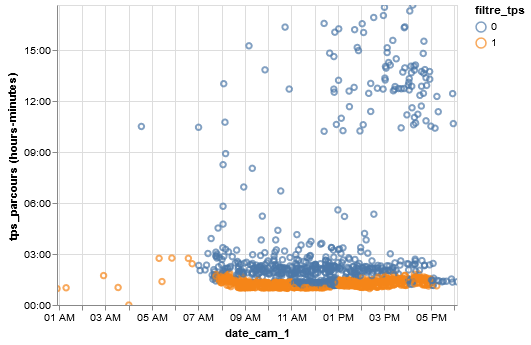

In [11]:
#exemple de visu
t.graph_transit_filtre(df_transit_avec_filtre, 'N10-A63')

POURCENTAGE PL PAR PLAGE HORAIRE ET CAMERA

In [432]:
#isoler pl source
groupe_tv_type_simple=df_journee.groupby('immat')['l'].apply(lambda x:test_unicite_type(list(x),mode='1/2')).reset_index().drop_duplicates('immat')
df_pl=df_journee.join(groupe_tv_type_simple.loc[groupe_tv_type_simple['l']==1].set_index('immat'),on='immat',how='inner',rsuffix='_right')
df_pl.set_index('created',inplace=True)

#obtenir les nb de pl par heure et par camera sur la source
df_synthese_pl_tot=df_pl.groupby('camera_id').resample('H').count()['immat'].rename(column={'immat':'nb_pl_tot'})
df_synthese_pl_transit=dico_passag.set_index('created').groupby('camera_id').resample('H').count()['immat'].rename(column={'immat':'nb_pl_transit'})
df_pct_pl_transit=pd.concat([df_synthese_pl_tot,df_synthese_pl_transit], axis=1, join='inner')
df_pct_pl_transit.columns=[['nb_pl_tot','nb_pl_transit']]
df_pct_pl_transit['pct_pl_transit']=df_pct_pl_transit.apply(lambda x : float(x['nb_pl_transit'])*100 / x['nb_pl_tot'] ,axis=1)
df_pct_pl_transit

In [ ]:
pct_pl=t.pourcentage_pl_camera('2019-01-28 00:00:00', 1,df_3semaines.reset_index(),dico_passag)
pct_pl

VERIFICATION

In [ ]:
# #retrouver une immatriculatiob dans les données completes
df_3semaines.loc[df_3semaines['immat']=='4c09dbea0bdad633c3ac4a88933f969996e242b2']

In [159]:
# retrouver une immatriculatiob dans ledico o_d
dico_od.loc[dico_od['immat']=='b4a14d6f285826ae2d1d6042c7ab13e2d01b98d0']

date_cam_1                                     immat state  l  \
18 2019-01-29 07:44:45  b4a14d6f285826ae2d1d6042c7ab13e2d01b98d0    ES  1   

            date_cam_2      cameras origine destination      o_d tps_parcours  \
18 2019-01-29 09:10:44  (6, 18, 13)     N10         A63  N10-A63     01:25:59   

             period  
18 2019-01-29 07:30

In [27]:
#verif a un horaire donne sur un trajet direct ou indirect ou global
#%time trajet_test=t.trajet(df_3semaines.loc['2019-01-29 00:00:00':'2019-01-30 23:59:59'], '2019-01-29 00:00:00', 1440, [15, 19],modeRegroupement='aucun')
"""%time test=t.trajet(df_3semaines.loc['2019-01-29 00:00:00':'2019-01-30 23:59:59'], '2019-01-29 00:00:00', 1440, [15, 19,4],typeTrajet='Indirect',
                     modeRegroupement='aucun')"""
test=t.trajet(df_3semaines.loc['2019-01-29 00:00:00':'2019-01-30 23:59:59'], '2019-01-29 12:00:00', 60, [15, 11],typeTrajet='Global',temps_max_autorise=18,
                     modeRegroupement='1/2')

In [ ]:
liste1=test.df_transit.loc[(test.df_transit['o_d']=='A63-N10')].set_index(['immat','date_cam_1'])
liste2=dico_od.loc[dico_od['o_d']=='A63-N10'].set_index(['immat','date_cam_1'])
liste2.loc[~liste2.index.isin(liste1.index)]

In [278]:
test.df_transit.loc[test.df_transit['immat']=='4c09dbea0bdad633c3ac4a88933f969996e242b2']

Empty DataFrame
Columns: [date_cam_1, immat, state, l, date_cam_2, cameras, origine, destination, o_d, tps_parcours]
Index: []

In [ ]:
#dfdes temps de parcours max autorise
test.df_transit

In [ ]:
#graph des temps de parcours et temps max
test.graph()['A63-A89']

In [ ]:
dico_od.loc[dico_od['o_d']=='N10-A660']

TESTS A LA MANO

In [240]:
#pour trouver un trajet direct (sans disticntion de type ou autre)
test2=t.trouver_passages_consecutif(df_3semaines, '2019-01-29 00:00:00', '2019-01-29 23:59:59', 15, 19)
#test2=test2.set_index('created_y').sort_index()

In [286]:
%%time
#pour test des fonctions de trajets global

def filtrer_passage(liste, df_liste_trajet,cam) :
    """
    Récuperer les cameras qui correpondent à un trajet
    """
    for liste_cams in [a for a in liste_complete_trajet.cameras.tolist() if a[0]==cam] :
        if liste[:len(liste_cams)]==tuple(liste_cams):
            return liste[:len(liste_cams)]
    else : return liste

def recuperer_date_cam2(liste,liste_created,df_liste_trajet,cam):
    """
    Récuperer les horaires de passage des cameras qui correpondent à un trajet
    """
    for liste_cams in [a for a in liste_complete_trajet.cameras.tolist() if a[0]==cam] :
        if liste[:len(liste_cams)]==tuple(liste_cams):
            return liste_created[len(liste_cams)-1]
    else : return liste_created[-1]
    
def test_unicite_type(liste_l, mode='unique'):
    """test pour voir si un vehicule a ete toujours vu de la mme façon ou non
       en entre : liste de valeur de l (qui traduit si c'est u pl ou non) iisues d'une df
       en sortie : integer 0  ou 1 ou -1
       """ 
    if mode=='unique' : 
        if len(set(liste_l))==1 :
            return liste_l[0]
        else : 
            return -1
    elif mode=='1/2' :
        if any(liste_l)==1 : 
            return 1
        else : 
            return -1

camera1, camera2=15,5
df=df_3semaines.loc['2019-01-29 00:00:00':'2019-01-30 23:59:59'].copy()
df_duree=df.loc['2019-01-29 00:00:00':'2019-01-29 23:59:59']
df_duree_cam1=df_duree.loc[df_duree.loc[:,'camera_id']==camera1]
df_duree_autres_cam=df.loc[(df.loc[:,'immat'].isin(df_duree_cam1.loc[:,'immat']))]
groupe=(df_duree_autres_cam.sort_index().reset_index().groupby('immat').agg({'camera_id':lambda x : tuple(x), 'l': lambda x : test_unicite_type(list(x),'1/2'),
                                                                               'created':lambda x: tuple(x)}))
groupe_pl=groupe.loc[groupe['l']==1].copy()
groupe_pl['camera_id']=groupe_pl.apply(lambda x : filtrer_passage(x['camera_id'],liste_complete_trajet,camera1),axis=1)#on filtre les cameras selon la liste des trajets existants
groupe_pl['created']=groupe_pl.apply(lambda x : recuperer_date_cam2(x['camera_id'],x['created'],liste_complete_trajet,camera1),axis=1)
df_ts_trajets=(groupe_pl.reset_index().merge(liste_complete_trajet[['cameras','origine','destination']],right_on='cameras', left_on='camera_id').
               rename(columns={'created':'date_cam_2'}).drop('camera_id',axis=1))
df_ts_trajets['o_d']=df_ts_trajets.apply(lambda x : x['origine']+'-'+x['destination'],axis=1)
df_agrege=df_duree_cam1.reset_index().merge(df_ts_trajets,on='immat').drop(['camera_id', 'l_x','state','fiability'],axis=1).rename(columns={'l_y':'l','created':'date_cam_1'})
df_agrege['tps_parcours']=df_agrege.apply(lambda x : x.date_cam_2-x.date_cam_1, axis=1)
df_agrege=df_agrege.loc[df_agrege['date_cam_2'] > df_agrege['date_cam_1']]

df_joint_passag_transit=df_agrege.merge(df_duree_autres_cam.reset_index(), on='immat')
df_passag_transit1=df_joint_passag_transit.loc[(df_joint_passag_transit.apply(lambda x : x['camera_id'] in x['cameras'], axis=1))]
df_passag_transit=(df_passag_transit1.loc[df_passag_transit1.apply(lambda x : x['date_cam_1']<=x['created']<=x['date_cam_2'], axis=1)]
                [['created','camera_id','immat','fiability','l_y','state']].rename(columns={'l_y':'l'}))
df_passag_transit

In [294]:
groupe_pl.loc['4c09dbea0bdad633c3ac4a88933f969996e242b2']

camera_id                                                        (13, 15, 5)
l                                                                          1
created      (2019-01-29 00:17:00, 2019-01-29 05:10:00, 2019-01-29 06:08:44)
Name: 4c09dbea0bdad633c3ac4a88933f969996e242b2, dtype: object

nb clusters = 1
tps parcours max : 0 days 18:38:42, final : 0 days 18:38:42


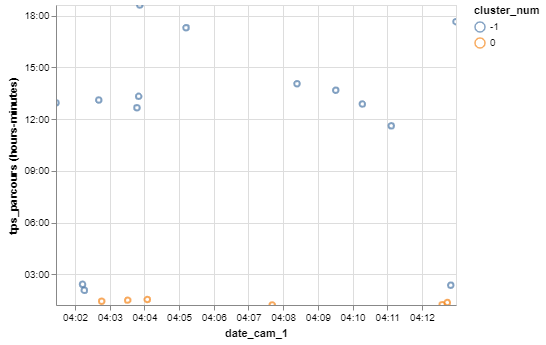

In [49]:
## pour tests des cluster
test=t.trajet(df_3semaines.loc['2019-01-29 00:00:00':'2019-01-30 23:59:59'], '2019-01-29 16:00:00', 15, [6, 13],typeTrajet='Global',temps_max_autorise=18,
                     modeRegroupement='1/2')
donnees=test.df_transit[test.df_transit['o_d']=='N10-A63'].copy()
donnees_src=donnees.loc[:,['date_cam_1','tps_parcours']].copy() #isoler les données necessaires
liste_valeur=donnees_src.tps_parcours.apply(lambda x : ((pd.to_datetime('2018-01-29')+x)-pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')).tolist()#convertir les temps en integer
liste_date=donnees_src.date_cam_1.apply(lambda x :(x - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')).tolist()
liste=[[liste_date[i],liste_valeur[i]] for i in range(len(liste_valeur))]
if len(liste_valeur)<10 : #si il n'y a pas bcp de pl on arrete ; pourraitfair l'objet d'un parametre
    raise ClusterError()
#mise en forme des données pour passer dans sklearn 
matrice=np.array(liste_valeur).reshape(-1, 1)
#faire tourner la clusterisation et recupérer le label (i.e l'identifiant cluster) et le nombre de cluster
clustering=DBSCAN(eps=1300, min_samples=len(liste_valeur)/4).fit(liste)
labels = clustering.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print(f"nb clusters = {n_clusters_}")
results = pd.DataFrame(pd.DataFrame([donnees_src.index,labels]).T)
results.columns = ['index_base', 'cluster_num']
results = pd.merge(results,donnees_src, left_on='index_base', right_index=True )
temp_parcours_max=results.loc[results.loc[:,'cluster_num']!=0].groupby(['cluster_num'])['tps_parcours'].max().min()
temp_parcours_max2=temp_parcours_max
copie_df=results.copy()
copie_df.tps_parcours=pd.to_datetime('2018-01-29')+copie_df.tps_parcours
graph_tps_parcours = alt.Chart(copie_df).mark_point().encode(
                            x='date_cam_1',
                            y='hoursminutes(tps_parcours)', color='cluster_num:N',
                            tooltip='hoursminutes(tps_parcours)').interactive()
print(f'tps parcours max : {temp_parcours_max}, final : {temp_parcours_max2}')
graph_tps_parcours

In [ ]:
results = pd.merge(results,donnees_src, left_on='index_base', right_index=True )

TESTS

In [122]:
a660_n10=dico_od.loc[dico_od['o_d']=='N10-A63'].copy()
a660_n10=a660_n10[a660_n10.apply(lambda x : x['date_cam_1'].to_period('D')==pd.Period('2019-01-29',freq='D'), axis=1)].reset_index().drop('index', axis=1)
a660_n10.tps_parcours=pd.to_datetime('2018-01-28')+a660_n10.tps_parcours

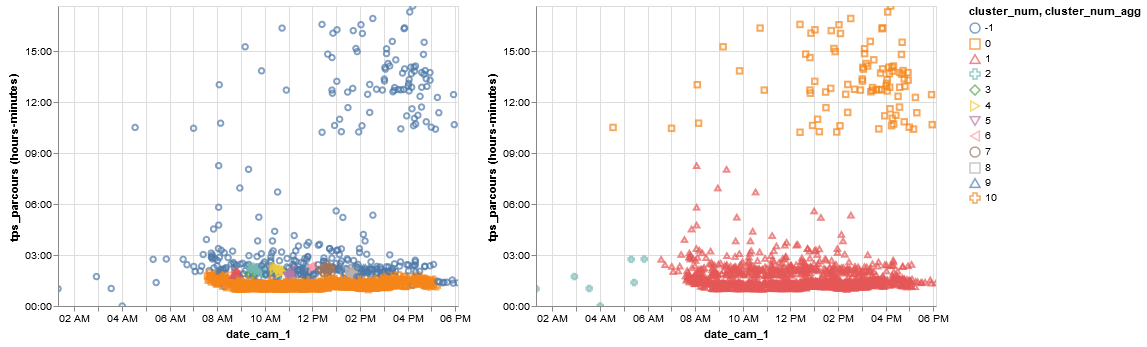

In [123]:
donnees_src=a660_n10.loc[:,['date_cam_1','tps_parcours']].copy() #isoler les données necessaires
#temps_int=((pd.to_datetime('2018-01-28')+donnees_src['tps_parcours'])-pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
liste_date=a660_n10.date_cam_1.apply(lambda x :(x - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s'))
liste_valeur=a660_n10.tps_parcours.apply(lambda x :(x - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s'))
liste=[[liste_date[i],liste_valeur[i]] for i in range(len(liste_valeur))]
donnnes = temps_int.values
matrice=donnnes.reshape(-1, 1)
clustering=DBSCAN(eps=725, min_samples=10).fit(liste)
labels = clustering.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
results = pd.DataFrame(pd.DataFrame([donnees_src.index,labels]).T)
results.columns = ['index_base', 'cluster_num']
results = pd.merge(results,a660_n10, left_on='index_base', right_index=True )

#results.tps_parcours=pd.to_datetime('2018-01-01')+results.tps_parcours
graph_tps_parcours1 = alt.Chart(results).mark_point().encode(
                            x='date_cam_1',
                            y='hoursminutes(tps_parcours)',
                            color='cluster_num:N',
                            shape='cluster_num:N',
                            tooltip='hoursminutes(tps_parcours)').interactive()

connectivity = kneighbors_graph(liste, n_neighbors=5, include_self=False)
ward = AgglomerativeClustering(n_clusters=3, 
                               linkage='average').fit(liste)
label_agg = ward.labels_
resultas = pd.DataFrame(pd.DataFrame([donnees_src.index,label_agg]).T)
resultas.columns = ['index_base', 'cluster_num_agg']
resultas = pd.merge(resultas,a660_n10, left_on='index_base', right_index=True )
#resultas.tps_parcours=pd.to_datetime('2018-01-01')+results.tps_parcours
graph_tps_parcours2 = alt.Chart(resultas).mark_point().encode(
                            x='date_cam_1',
                            y='hoursminutes(tps_parcours)',
                            color='cluster_num_agg:N',
                            shape='cluster_num_agg:N',
                            tooltip='hoursminutes(tps_parcours)').interactive()


graph_tps_parcours1 | graph_tps_parcours2

In [52]:
def filtre_tps_parcours(date_passage,tps_parcours, type_tps_lapi, tps_lapi, tps_theoriq, marge) : 
        """pour ajouter un attribut drapeau sur le tempsde parcours, et ne conserver que les trajets de transit"""
        
        if date_passage.hour in [20,21,22,23,0,1,2,3,4,5,6] : 
            marge += 480 #si le gars passe la nuit, on lui ajoute 8 heure de marge
        if type_tps_lapi=='Cluster':
            if tps_parcours < tps_lapi+pd.Timedelta(str(marge)+'min') :
                return 1
            else: 
                return 0
        else : 
            if tps_parcours < tps_theoriq+pd.Timedelta(str(marge)+'min') :
                return 1
            else: 
                return 0
def periode_carac(date_passage) :
    """
    pour calculer la période de passage selon une date
    """
    if date_passage.hour in [6,7,8,14,15,16,17,18,19] : 
        return date_passage.floor('15min').to_period('15min')
    else : 
        return date_passage.to_period('H')

In [132]:
dico_od_tps=dico_od.copy()
dico_tps_max_tps=dico_tps_max.copy()

In [133]:
dico_od_tps['period']=dico_od.apply(lambda x : periode_carac(x['date_cam_1']),axis=1)

In [134]:
dico_tps_max_tps['period']=dico_tps_max_tps.apply(lambda x : periode_carac(x['date']),axis=1)

In [135]:
df_transit_tps_parcours=dico_od_tps.merge(dico_tps_max_tps, on=['o_d','period'],how='left').merge(liste_complete_trajet[['cameras','tps_parcours_theoriq' ]], on='cameras')
df_transit_tps_parcours['filtre_tps']=df_transit_tps_parcours.apply(lambda x : filtre_tps_parcours(x['date_cam_1'],
                                                                x['tps_parcours'], x['type'], x['temps'], x['tps_parcours_theoriq'],10), axis=1)

In [127]:
dico_tps_max.loc[dico_tps_max['date']=='2019-01-29 16:45:00'].sort_values(['o_d']).head(30)

date           temps              type       o_d
0 2019-01-29 16:45:00 11:16:59.599999  85eme_percentile   A10-A62
2 2019-01-29 16:45:00 14:10:11.600000  85eme_percentile   A10-A63
1 2019-01-29 16:45:00 14:46:51.200000  85eme_percentile  A10-A660
4 2019-01-29 16:45:00        00:38:29  85eme_percentile   A62-A10
3 2019-01-29 16:45:00        13:58:03  85eme_percentile   A62-A63
2 2019-01-29 16:45:00 10:46:43.400000  85eme_percentile  A62-A660
0 2019-01-29 16:45:00        16:21:51  85eme_percentile   A62-A89
1 2019-01-29 16:45:00 00:13:46.900000  85eme_percentile   A62-N10
1 2019-01-29 16:45:00 12:47:42.900000  85eme_percentile   A63-A10
2 2019-01-29 16:45:00        01:07:52  85eme_percentile   A63-A62
0 2019-01-29 16:45:00        01:25:20           Cluster   A63-N10
2 2019-01-29 16:45:00        00:39:29  85eme_percentile  A660-A62
0 2019-01-29 16:45:00        17:25:33  85eme_percentile  A660-A89
1 2019-01-29 16:45:00 00:55:00.200000  85eme_percentile  A660-N10
1 2019-01-29 16:45:00 01:17:39.150000  85eme_percentile   A89-A63
0 2019-01-29 16:45:00        16:13:53  85eme_percentile  A89-A660
1 2019-01-29 16:45:00 00:33:43.500000  85eme_percentile   N10-A62
0 2019-01-29 16:45:00        01:15:52           Cluster   N10-A63
2 2019-01-29 16:45:00        00:42:23  85eme_percentile  N10-A660

In [115]:
dico_tps_max_tps.loc[dico_tps_max_tps['date']=='2019-01-29 16:45:00'].sort_values(['o_d']).head(30)

date           temps              type       o_d  \
0 2019-01-29 16:45:00 11:16:59.599999  85eme_percentile   A10-A62   
2 2019-01-29 16:45:00 14:10:11.600000  85eme_percentile   A10-A63   
1 2019-01-29 16:45:00 14:46:51.200000  85eme_percentile  A10-A660   
4 2019-01-29 16:45:00        00:38:29  85eme_percentile   A62-A10   
3 2019-01-29 16:45:00        13:58:03  85eme_percentile   A62-A63   
2 2019-01-29 16:45:00 10:46:43.400000  85eme_percentile  A62-A660   
0 2019-01-29 16:45:00        16:21:51  85eme_percentile   A62-A89   
1 2019-01-29 16:45:00 00:13:46.900000  85eme_percentile   A62-N10   
1 2019-01-29 16:45:00 12:47:42.900000  85eme_percentile   A63-A10   
2 2019-01-29 16:45:00        01:07:52  85eme_percentile   A63-A62   
0 2019-01-29 16:45:00        01:25:20           Cluster   A63-N10   
2 2019-01-29 16:45:00        00:39:29  85eme_percentile  A660-A62   
0 2019-01-29 16:45:00        17:25:33  85eme_percentile  A660-A89   
1 2019-01-29 16:45:00 00:55:00.200000  85eme_percentile  A660-N10   
1 2019-01-29 16:45:00 01:17:39.150000  85eme_percentile   A89-A63   
0 2019-01-29 16:45:00        16:13:53  85eme_percentile  A89-A660   
1 2019-01-29 16:45:00 00:34:19.950000  85eme_percentile   N10-A62   
0 2019-01-29 16:45:00        01:15:52           Cluster   N10-A63   
2 2019-01-29 16:45:00        00:42:23  85eme_percentile  N10-A660   

            period  
0 2019-01-29 16:45  
2 2019-01-29 16:45  
1 2019-01-29 16:45  
4 2019-01-29 16:45  
3 2019-01-29 16:45  
2 2019-01-29 16:45  
0 2019-01-29 16:45  
1 2019-01-29 16:45  
1 2019-01-29 16:45  
2 2019-01-29 16:45  
0 2019-01-29 16:45  
2 2019-01-29 16:45  
0 2019-01-29 16:45  
1 2019-01-29 16:45  
1 2019-01-29 16:45  
0 2019-01-29 16:45  
1 2019-01-29 16:45  
0 2019-01-29 16:45  
2 2019-01-29 16:45

In [136]:
len(dico_od_tps)

10469

In [137]:
len(df_transit_tps_parcours)

10469

In [138]:
pd.isnull(df_transit_tps_parcours).any(1).nonzero()[0]

array([], dtype=int64)

In [119]:
df_transit_tps_parcours.iloc[42]

date_cam_1                                   2019-01-29 14:34:17
immat                   67c43122cf380564b1e938fce6328ac5556b140b
state                                                         ES
l                                                              1
date_cam_2                                   2019-01-29 16:44:56
cameras                                          (15, 19, 5, 11)
origine                                                      A63
destination                                                  A10
o_d                                                      A63-A10
tps_parcours                                     0 days 02:10:39
period                                          2019-01-29 14:30
date                                                         NaT
temps                                                        NaT
type                                                         NaN
tps_parcours_theoriq                      0 days 01:30:14.634000
filtre_tps               

In [122]:
dico_tps_max.loc[(dico_tps_max['o_d']=='A63-A10')&(dico_tps_max['date']>'2019-01-29 14:00:00')].sort_values('date')

date           temps              type      o_d
1 2019-01-29 14:15:00 02:36:47.500000  85eme_percentile  A63-A10
0 2019-01-29 14:30:00        02:03:10  85eme_percentile  A63-A10
2 2019-01-29 14:45:00 01:54:12.500000  85eme_percentile  A63-A10
1 2019-01-29 15:00:00        03:02:55  85eme_percentile  A63-A10
1 2019-01-29 15:15:00 02:27:15.200000  85eme_percentile  A63-A10
1 2019-01-29 15:30:00 02:45:31.900000  85eme_percentile  A63-A10
2 2019-01-29 15:45:00 02:35:31.500000  85eme_percentile  A63-A10
1 2019-01-29 16:00:00 14:42:26.600000  85eme_percentile  A63-A10
1 2019-01-29 16:15:00 15:50:05.900000  85eme_percentile  A63-A10
1 2019-01-29 16:30:00 02:34:55.300000  85eme_percentile  A63-A10
1 2019-01-29 16:45:00 12:47:42.900000  85eme_percentile  A63-A10

In [48]:
rng = pd.date_range('1/1/2018 11:59:00', periods=3, freq='min')

In [49]:
rng

DatetimeIndex(['2018-01-01 11:59:00', '2018-01-01 12:00:00',
               '2018-01-01 12:01:00'],
              dtype='datetime64[ns]', freq='T')

In [51]:
rng.floor('15min')

DatetimeIndex(['2018-01-01 11:45:00', '2018-01-01 12:00:00',
               '2018-01-01 12:00:00'],
              dtype='datetime64[ns]', freq=None)

In [105]:
temps_parcours_max=dico_od.loc[(dico_od['o_d']=='A10-A63') & (dico_od['date_cam_1']>'2019-01-29 20:00:00') & 
                               (dico_od['date_cam_1']<'2019-01-29 20:15:00')]#.tps_parcours.quantile(0.85)

In [106]:
temps_parcours_max#.tps_parcours.quantile(0.85)

Empty DataFrame
Columns: [date_cam_1, immat, state, l, date_cam_2, cameras, origine, destination, o_d, tps_parcours]
Index: []

In [99]:
liste_date=[]
for date in pd.date_range('2019-01-29', periods=1*24, freq='H') : 
        if date.hour in [6,7,8,14,15,16,17,18,19] : 
            for date_15m in pd.date_range(date, periods=4, freq='15T') :
                liste_date.append([date_15m,15])
        else: 
            liste_date.append([date,60])

In [47]:
dico_od_graph=dico_od.copy()
dico_od_graph.tps_parcours=pd.to_datetime('2019-01-29')+dico_od_graph.tps_parcours

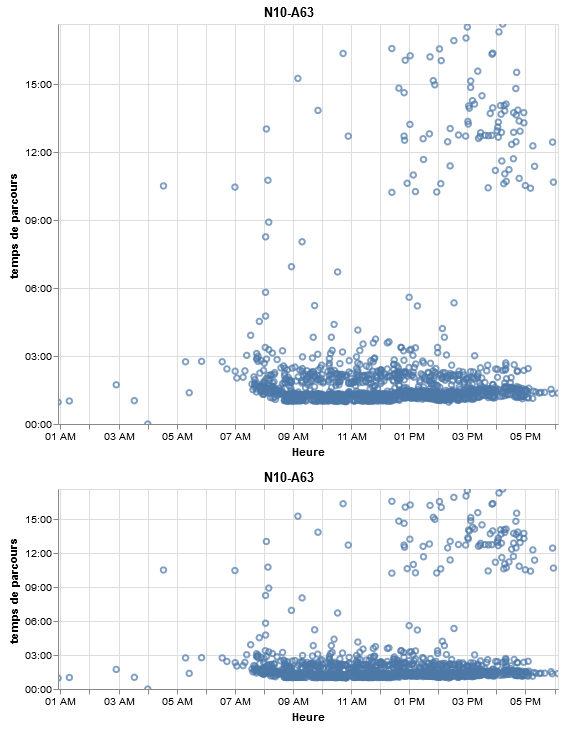

In [86]:
brush = alt.selection(type='interval', encodings=['y'])
up = alt.Chart(g_a63_n10,title='A10-A63').mark_point().encode(
                            x=alt.X('date_cam_1:T',scale=alt.Scale(zero=False),title='Heure'),
                            y=alt.Y('hoursminutes(tps_parcours)',scale={'domain': brush.ref()},title='temps de parcours')).properties(width=500, height=200)
low=up.properties(
    height=400
).add_selection(brush)
alt.vconcat(low, up)

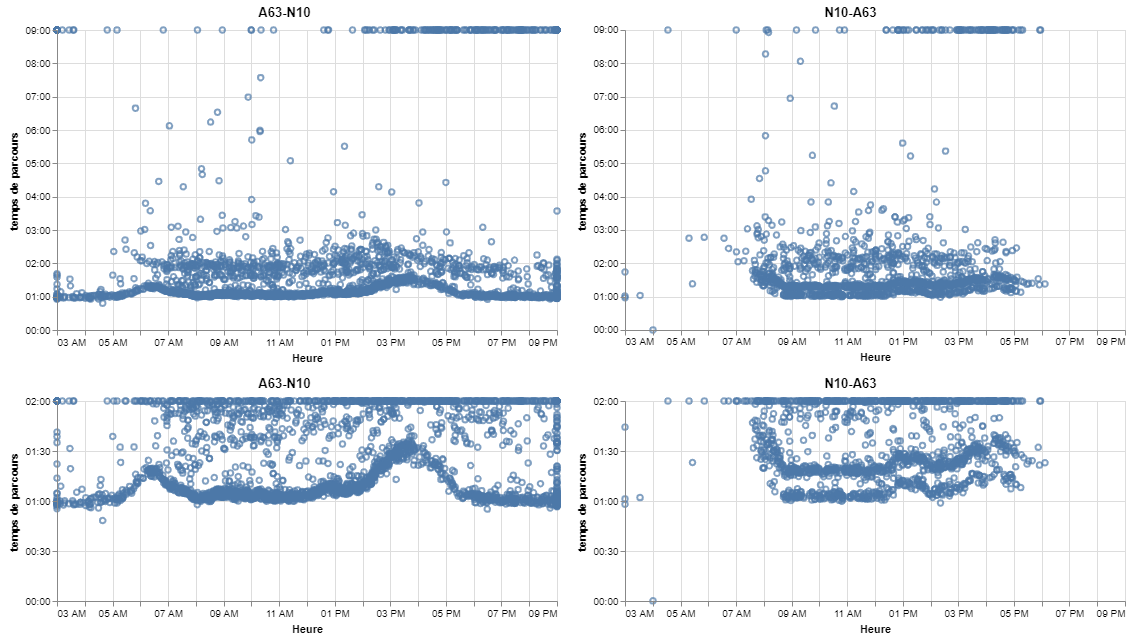

In [48]:
base_a63_n10 = alt.Chart(dico_od_graph.loc[dico_od_graph['o_d']=='N10-A63'], title='N10-A63').mark_point().encode(
                            x=alt.X('date_cam_1:T',title='Heure',scale=alt.Scale(domain=('2019-01-29 03:00:00','2019-01-29 21:00:00'),clamp=True))
                            )
up_a63_n10=base_a63_n10.encode(y=alt.Y('tps_parcours',axis=alt.Axis(title='temps de parcours', format='%H:%M'),
                       scale=alt.Scale(domain=('2019-01-29 00:00:00','2019-01-29 09:00:00'),clamp=True))).properties(width=500, height=300)
low_a63_n10=base_a63_n10.encode(y=alt.Y('tps_parcours',axis=alt.Axis(title='temps de parcours', format='%H:%M'),
                       scale=alt.Scale(domain=('2019-01-29 00:00:00','2019-01-29 02:00:00'),clamp=True))).properties(width=500, height=200)
a63_n10=alt.vconcat(up_a63_n10,low_a63_n10)

base_n10_a63 = alt.Chart(dico_od_graph.loc[dico_od_graph['o_d']=='A63-N10'], title='A63-N10').mark_point().encode(
                            x=alt.X('date_cam_1:T',title='Heure',scale=alt.Scale(domain=('2019-01-29 03:00:00','2019-01-29 21:00:00'),clamp=True))
                            )
up_n10_a63=base_n10_a63.encode(y=alt.Y('tps_parcours',axis=alt.Axis(title='temps de parcours', format='%H:%M'),
                       scale=alt.Scale(domain=('2019-01-29 00:00:00','2019-01-29 09:00:00'),clamp=True))).properties(width=500, height=300)
low_n10_a63=base_n10_a63.encode(y=alt.Y('tps_parcours',axis=alt.Axis(title='temps de parcours', format='%H:%M'),
                       scale=alt.Scale(domain=('2019-01-29 00:00:00','2019-01-29 02:00:00'),clamp=True))).properties(width=500, height=200)
n10_a63=alt.vconcat(up_n10_a63,low_n10_a63)
n10_a63|a63_n10

DataTransformerRegistry.enable('default')

In [262]:
param_cluster=pd.DataFrame({'trajet':[('A10-A63','N10-A63','A89-A63','A62-A63','A10-A62','N10-A62','A89-A62','A10-A89','N10-A89','A10-A660','N10-A660','A89-A660','A62-A660'),
                        ('A10-A63','N10-A63','A89-A63','A62-A63','A10-A62','N10-A62','A89-A62','A10-A89','N10-A89','A10-A660','N10-A660','A89-A660','A62-A660'),
                        ('A63-A10','A63-N10','A63-A89','A63-A62','A62-A10','A62-N10','A62-A89','A89-A10','A89-N10','A660-A10','A660-N10','A660-A89','A660-A62'),
                        ('A63-A10','A63-N10','A63-A89','A63-A62','A62-A10','A62-N10','A62-A89','A89-A10','A89-N10','A660-A10','A660-N10','A660-A89','A660-A62'),
                       ],
              'temps_etudie':[15,60,15,60],
              'delai':[600,1200,800,1000],
              'nb_pt_min':[4,4,3,4]
             })
param_cluster=pd.read_json(r'Q:\DAIT\TI\DREAL33\2018\C17SI0073_LAPI\Traitements\python\param_cluster.json', orient='index')

In [278]:
"""%time test=t.trajet(df_3semaines.loc['2019-01-29 00:00:00':'2019-01-30 23:59:59'], '2019-01-29 00:00:00', 1440, [15, 19,4],typeTrajet='Indirect',
                     modeRegroupement='aucun')"""
test=t.trajet(df_3semaines.loc['2019-01-29 00:00:00':'2019-01-30 23:59:59'], '2019-01-29 10:00:00', 60, [15,11],typeTrajet='Global',temps_max_autorise=18,
                     modeRegroupement='1/2')

In [279]:
test.temps_parcours_max

date    temps              type      o_d
0 2019-01-29 10:00:00 01:22:38           Cluster  A63-N10
1 2019-01-29 10:00:00 02:49:06  85eme_percentile  A63-A10
2 2019-01-29 10:00:00 01:11:32           Cluster  A63-A89
3 2019-01-29 10:00:00 00:53:18           Cluster  A63-A62

In [160]:
param_cluster[(param_cluster.trajet.apply(lambda x : 'A10-A63' in x)) & (param_cluster['temps_etudie']==15)].delai.values[0]

600

In [263]:
param_cluster

delai  nb_pt_min  temps_etudie  \
0    600          4            15   
1   1200          4            60   
2    800          3            15   
3   1000          4            60   

                                                                                                                      trajet  
0  [A10-A63, N10-A63, A89-A63, A62-A63, A10-A62, N10-A62, A89-A62, A10-A89, N10-A89, A10-A660, N10-A660, A89-A660, A62-A660]  
1  [A10-A63, N10-A63, A89-A63, A62-A63, A10-A62, N10-A62, A89-A62, A10-A89, N10-A89, A10-A660, N10-A660, A89-A660, A62-A660]  
2  [A63-A10, A63-N10, A63-A89, A63-A62, A62-A10, A62-N10, A62-A89, A89-A10, A89-N10, A660-A10, A660-N10, A660-A89, A660-A62]  
3  [A63-A10, A63-N10, A63-A89, A63-A62, A62-A10, A62-N10, A62-A89, A89-A10, A89-N10, A660-A10, A660-N10, A660-A89, A660-A62]

In [255]:
liste_complete_trajet.loc[liste_complete_trajet['cameras']==(15, 19, 4, 5, 11)].o_d.values[0]

'A63-A10'

In [15]:
df_3semaines['created']=df_3semaines.apply(lambda x : pd.to_datetime(x['created']),axis=1)

In [19]:
df_3semaines

camera_id  fiability  \
created                                            
1970-01-01 00:25:48.633600          5         99   
1970-01-01 00:25:48.633601         19         99   
1970-01-01 00:25:48.633602          5         99   
1970-01-01 00:25:48.633605          5         78   
1970-01-01 00:25:48.633607         10         57   
1970-01-01 00:25:48.633608         18         59   
1970-01-01 00:25:48.633608          3         99   
1970-01-01 00:25:48.633610          3         89   
1970-01-01 00:25:48.633611          3         99   
1970-01-01 00:25:48.633613          3         99   
1970-01-01 00:25:48.633614          3         99   
1970-01-01 00:25:48.633616          4         99   
1970-01-01 00:25:48.633617          3         55   
1970-01-01 00:25:48.633619         10         79   
1970-01-01 00:25:48.633621          4         99   
1970-01-01 00:25:48.633624          5         79   
1970-01-01 00:25:48.633629         19         99   
1970-01-01 00:25:48.633631          3         69   
1970-01-01 00:25:48.633633         19         67   
1970-01-01 00:25:48.633636         10         89   
1970-01-01 00:25:48.633638          3         89   
1970-01-01 00:25:48.633639         19         99   
1970-01-01 00:25:48.633646         10         99   
1970-01-01 00:25:48.633647          4         99   
1970-01-01 00:25:48.633649         15         89   
1970-01-01 00:25:48.633651          8         56   
1970-01-01 00:25:48.633653          3         89   
1970-01-01 00:25:48.633653          2         66   
1970-01-01 00:25:48.633655          3         38   
1970-01-01 00:25:48.633658          3         99   
...                               ...        ...   
1970-01-01 00:25:49.925960          3         99   
1970-01-01 00:25:49.925961          3         99   
1970-01-01 00:25:49.925962          3         99   
1970-01-01 00:25:49.925964          9         59   
1970-01-01 00:25:49.925968         15         99   
1970-01-01 00:25:49.925969          1         22   
1970-01-01 00:25:49.925971          5         99   
1970-01-01 00:25:49.925972          6         99   
1970-01-01 00:25:49.925973          5         99   
1970-01-01 00:25:49.925973          4         89   
1970-01-01 00:25:49.925974          9         77   
1970-01-01 00:25:49.925974          3         79   
1970-01-01 00:25:49.925975          3         99   
1970-01-01 00:25:49.925976          3         99   
1970-01-01 00:25:49.925976          5         99   
1970-01-01 00:25:49.925978         18         99   
1970-01-01 00:25:49.925978         11         99   
1970-01-01 00:25:49.925978          3         69   
1970-01-01 00:25:49.925980         10         99   
1970-01-01 00:25:49.925981          5         99   
1970-01-01 00:25:49.925983          5         78   
1970-01-01 00:25:49.925984          7         99   
1970-01-01 00:25:49.925986          6         99   
1970-01-01 00:25:49.925986          3         89   
1970-01-01 00:25:49.925989          5         99   
1970-01-01 00:25:49.925991          5         99   
1970-01-01 00:25:49.925991         18         99   
1970-01-01 00:25:49.925991          7         89   
1970-01-01 00:25:49.925996         12         69   
1970-01-01 00:25:49.925997          3         89   

                                                               immat  l  state  
created                                                                         
1970-01-01 00:25:48.633600  d67f03dae600b3866a4d56d0eb2e2dbd6718097a  0     ES  
1970-01-01 00:25:48.633601  7e35f81e0a03468736e42733b5e5efd4cbb0d29d  0     PT  
1970-01-01 00:25:48.633602  d1724cc8fed2c21e3700b59fcdfc0b6b0720700f  0     ES  
1970-01-01 00:25:48.633605  4bef1bac1f9833d59d40cbf266f5cc8c919114b8  0     ES  
1970-01-01 00:25:48.633607  c95435801c64f6ef7530afc9fa9d0ae4ac61cf41  0     FR  
1970-01-01 00:25:48.633608  3fc7ef985d47b567d2402c754eb13144ff922c4b  0     FR  
1970-01-01 00:25:48.633608  2fd1290944b72d09abdf71d93afc7ef7c6e43e70  0     FR  
1970-01-01 00:25:48.63